# Regresión Lineal - Capítulo 5

Análisis de regresión lineal con diferentes técnicas de regularización usando el dataset de Toyota Corolla.


## Importar librerías


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as sm
import matplotlib.pylab as plt
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score


## Cargar datos y preparar variables


In [5]:
############### code for fitting a regression model to training set and predicting
############### code for fitting a regression model
# reduce data frame to the top 1000 rows and select columns for regression analysis
car_df = pd.read_csv(".//ToyotaCorolla.csv")
car_df = car_df.iloc[0:1000]
predictors = ["Age_08_04", "KM", "Fuel_Type", "HP", "Met_Color", "Automatic","CC","Doors", "Quarterly_Tax", "Weight"]
outcome = "Price"
#car_df.dtypes
# partition data
X = pd.get_dummies(car_df[predictors], drop_first=True)
y = car_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4,random_state=1)


## Ajustar modelo de regresión lineal


In [6]:
car_lm = LinearRegression()
car_lm.fit(train_X, train_y)
# print coefficients
print(pd.DataFrame({"Predictor": X.columns, "coefficient": car_lm.coef_}))
# print performance measures (training data)
regressionSummary(train_y, car_lm.predict(train_X))


           Predictor  coefficient
0          Age_08_04  -140.748761
1                 KM    -0.017840
2                 HP    36.103419
3          Met_Color    84.281830
4          Automatic   416.781954
5                 CC     0.017737
6              Doors   -50.657863
7      Quarterly_Tax    13.625325
8             Weight    13.038711
9   Fuel_Type_Diesel  1066.464681
10  Fuel_Type_Petrol  2310.249543

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 1400.5823
            Mean Absolute Error (MAE) : 1046.9072
          Mean Percentage Error (MPE) : -1.0223
Mean Absolute Percentage Error (MAPE) : 9.2994


## Predicciones en conjunto de validación


In [7]:
############### prices in validation set
# Use predict() to make predictions on a new set
car_lm_pred = car_lm.predict(valid_X)
result = pd.DataFrame({"Predicted": car_lm_pred, "Actual": valid_y,"Residual": valid_y - car_lm_pred})
print(result.head(20))
# print performance measures (validation data)
regressionSummary(valid_y, car_lm_pred)


        Predicted  Actual     Residual
507  10607.333940   11500   892.666060
818   9272.705792    8950  -322.705792
452  10617.947808   11450   832.052192
368  13600.396275   11450 -2150.396275
242  12396.694660   11950  -446.694660
929   9496.498212    9995   498.501788
262  12480.063217   13500  1019.936783
810   8834.146068    7950  -884.146068
318  12183.361282    9900 -2283.361282
49   19206.965683   21950  2743.034317
446  10987.498309   11950   962.501691
142  18501.527375   19950  1448.472625
968   9914.690947    9950    35.309053
345  13827.299932   14950  1122.700068
971   7966.732543   10495  2528.267457
133  17185.242041   15950 -1235.242041
104  19952.658062   19450  -502.658062
6    16570.609280   16900   329.390720
600  13739.409113   11250 -2489.409113
496  11267.513740   11750   482.486260

Regression statistics

                      Mean Error (ME) : 103.6803
       Root Mean Squared Error (RMSE) : 1312.8523
            Mean Absolute Error (MAE) : 1017.5972
        

## Histograma de errores de validación


0.7425


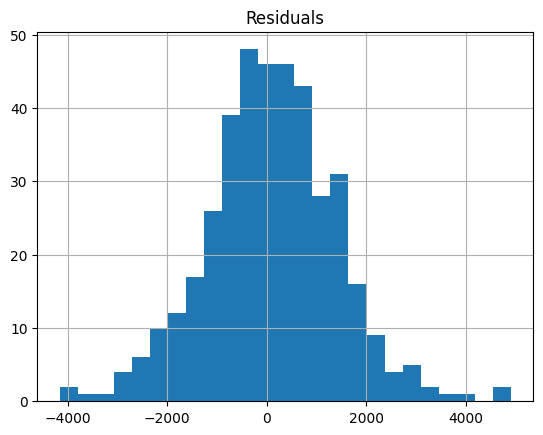

In [8]:
########## code for plotting histogram of validation errors
car_lm_pred = car_lm.predict(valid_X)
all_residuals = valid_y - car_lm_pred
# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx.
# 75%
print(len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) / len(all_residuals))
pd.DataFrame({"Residuals": all_residuals}).hist(bins=25)
plt.show()


## Búsqueda exhaustiva de predictores


In [9]:
############ Exhaustive search for reducing predictors in Toyota Corolla example
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[list(variables)], train_y)
    return model
def score_model(model, variables):
    pred_y = model.predict(train_X[list(variables)])
    # we negate as score is optimized to be as low as possible
    return -adjusted_r2_score(train_y, pred_y, model)
allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)
data = []
for result in results:
    model = result["model"]
    variables = list(result["variables"])
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)
    d = {"n": result["n"], "r2adj": -result["score"], "AIC": AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)
pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(allVariables)))


,n,r2adj,AIC,Age_08_04,Automatic,CC,Doors,Fuel_Type_Diesel,Fuel_Type_Petrol,HP,KM,Met_Color,Quarterly_Tax,Weight
0,1,0.767901,10689.712094,True,False,False,False,False,False,False,False,False,False,False
1,2,0.801160,10597.910645,True,False,False,False,False,False,True,False,False,False,False
2,3,0.829659,10506.084235,True,False,False,False,False,False,True,False,False,False,True
3,4,0.846357,10445.174820,True,False,False,False,False,False,True,True,False,False,True
4,5,0.849044,10435.578836,True,False,False,False,False,False,True,True,False,True,True
5,6,0.853172,10419.932278,True,False,False,False,False,True,True,True,False,True,True
6,7,0.853860,10418.104025,True,False,False,False,True,True,True,True,False,True,True
7,8,0.854297,10417.290103,True,True,False,False,True,True,True,True,False,True,True
8,9,0.854172,10418.789079,True,True,False,True,True,True,True,True,False,True,True
9,10,0.854036,10420.330800,True,True,False,True,True,True,True,True,True,True,True


### Tareas pendientes para Exhaustive Search
Usar el modelo seleccionado (Exhaustive search) para realizar:
1. Análisis predictivo 
2. Gráfico de residuales


In [ ]:
# Usar el modelo seleccionado (Exhaustive search) para realizar 
# 1.- análisis predictivo 
# 2.- Gráfico residuales 
#


## Regresión regularizada: Lasso


In [10]:
######### code for regularized linear regression
lasso = Lasso(normalize=True, alpha=1)
lasso.fit(train_X, train_y)
regressionSummary(valid_y, lasso.predict(valid_X))


TypeError: Lasso.__init__() got an unexpected keyword argument 'normalize'

### Tareas pendientes para Lasso
Usar el modelo seleccionado (lasso) para realizar:
1. Análisis predictivo 
2. Gráfico de residuales


In [ ]:
# Usar el modelo seleccionado (lasso) para realizar 
# 1.- análisis predictivo 
# 2.- Gráfico residuales 
#


## Lasso con validación cruzada (LassoCV)


In [ ]:
lasso_cv = LassoCV(normalize=True, cv=5)
lasso_cv.fit(train_X, train_y)
regressionSummary(valid_y, lasso_cv.predict(valid_X))
print("Lasso-CV chosen regularization: ", lasso_cv.alpha_)
print(lasso_cv.coef_)


### Tareas pendientes para LassoCV
Usar el modelo seleccionado (lassoCV) para realizar:
1. Análisis predictivo 
2. Gráfico de residuales


In [ ]:
# Usar el modelo seleccionado (lassoCV) para realizar 
# 1.- análisis predictivo 
# 2.- Gráfico residuales 
#


## Regresión Ridge


In [ ]:
ridge = Ridge(normalize=True, alpha=1)
ridge.fit(train_X, train_y)
regressionSummary(valid_y, ridge.predict(valid_X))


## Regresión Bayesiana Ridge


In [ ]:
bayesianRidge = BayesianRidge(normalize=True)
bayesianRidge.fit(train_X, train_y)
regressionSummary(valid_y, bayesianRidge.predict(valid_X))
alpha = bayesianRidge.lambda_ / bayesianRidge.alpha_
print('Bayesian ridge chosen regularization: ', alpha)
